# Remotely fetching NEXRAD data, gridding and intergration with MetPy and Siphon

This notebook highlights the power of having NEXRAD on Amazon Web Services Simple Storage Service (S3). We use a tool, which is pip installable, called nexradaws. We show how it works to download and use tempfile for easy access. How to build a simple (with issues) function. We also showcase Py-ART's multi-radar gridding capabilities. Finally we show how Py-ART and MetPy + Siphon can be used to make nice mosiacs with metars. **Note: the MetPy portion only works for cases less than a month old. Will need to be updated when this component is taught**.


In [1]:
import nexradaws
import tempfile
import os
import shutil
import pyart
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import metpy.calc as mpcalc
import metpy.plots as mpplots

import numpy as np

from matplotlib.patheffects import withStroke
from metpy.io import parse_metar_file
from metpy.units import pandas_dataframe_to_unit_arrays

# Here is where we import the TDSCatalog class from siphon for obtaining our data 
from siphon.catalog import TDSCatalog

import pytz


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
# Create a tempory file, connect nexrad aws and request a list of files from the 
#Chicago NEXRAD for the 10th of August last year

templocation = tempfile.mkdtemp()
conn = nexradaws.NexradAwsInterface()
scans = conn.get_avail_scans(2020, 8, 10,'KLOT')

In [3]:
#Download 5 files

lcn = templocation
localfiles = conn.download(scans[350:355],lcn)

Downloaded KLOT20200810_205734_V06_MDM
Downloaded KLOT20200810_205734_V06
Downloaded KLOT20200810_203633_V06
Downloaded KLOT20200810_205034_V06
Downloaded KLOT20200810_204334_V06
5 out of 5 files downloaded...0 errors


In [4]:
#Load one of the files

radar = pyart.io.read(localfiles.success[1].filepath)


/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/cartopy/crs.py:2320: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a = np.float(self.globe.semimajor_axis or WGS84_SEMIMAJOR_AXIS)
/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/cartopy/crs.py:2321: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecati

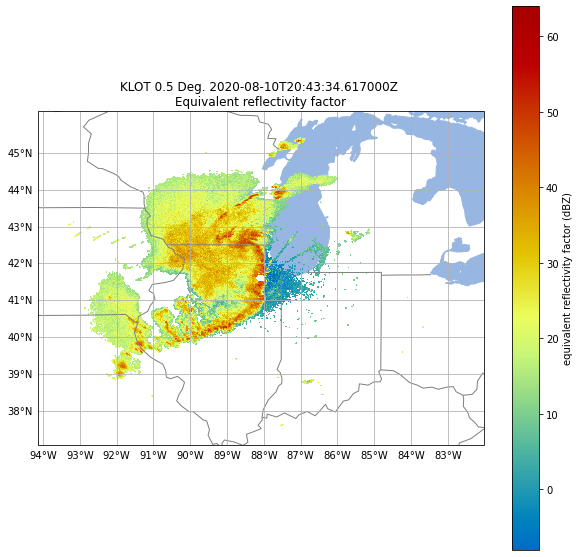

In [5]:
#Visualize. Set the projection first this time so we have some
#hand axes. Add the lakes at the bottom of the plot

myf = plt.figure(figsize=[10,10])
ax = plt.axes(projection=ccrs.PlateCarree())
myd = pyart.graph.RadarMapDisplay(radar)
ax.add_feature(cfeature.LAKES, zorder=0)

myd.plot_ppi_map('reflectivity', 0, vmin=-8, vmax=64)


## So this is cool.. How do we roll a custom function?

In [6]:
#Lets start by interrogating the scan object

a=scans[-1]
a.scan_time

datetime.datetime(2020, 8, 10, 23, 58, 50, tzinfo=<UTC>)

## An Aside, when it comes to coding...
And you want to do something, like, say, finding the cloest time to a given date.. **GOOGLE IT AND CLICK THE FIRST STACK OVERFLOW LINK**. Coding from scratch is very rare.. Most coding is by addition of subtraction to existing code (like this cookbook!).

In [7]:
#https://stackoverflow.com/questions/32237862/find-the-closest-date-to-a-given-date/32237949
def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

In [8]:
# Now, by trail and error I found that some scan[i].times are none.. so lets control for that

times = [scan.scan_time for scan in scans] # <--- Python generator... these can get you in trouble

#Need to clean
good_scans = []
good_times = []
for i in range(len(scans)):
    if times[i] is not None:
        good_times.append(times[i])
        good_scans.append(scans[i])
        
nearest_time = nearest(good_times, datetime(2020,8,10,20,6,55,0, pytz.UTC)) # <---- nexradaws times are TZ aware 


index = times.index(nearest_time)

In [9]:
#Lets see if this worked
print(index)

345


## Woot! It works! Now lets wrap it into a function

In [10]:
# This is a VERY LAZY function. 
#No testing and if it gets a file Py-ART can not read it will fail, ungracefully

def get_my_radar(connex, site, this_datetime):
    tlocation = tempfile.mkdtemp()
    these_scans = connex.get_avail_scans(this_datetime.year,this_datetime.month, this_datetime.day, site)
    these_times = [scan.scan_time for scan in these_scans]
    targ = this_datetime
    
    #Need to clean
    these_good_scans = []
    these_good_times = []
    for i in range(len(these_scans)):
        if these_times[i] is not None:
            these_good_times.append(these_times[i])
            these_good_scans.append(these_scans[i])
    
    print(len(these_good_scans), len(these_good_times))

    this_nearest_time = nearest(these_good_times, targ)
    this_index = these_good_times.index(this_nearest_time)
    lcn = templocation
    localfiles = conn.download(these_good_scans[this_index],lcn)
    return pyart.io.read(localfiles.success[0].filepath)

## Lets take this baby for a spin! 
Here are some dates (both timezone aware and naive) and radars when "stuff" happened.

In [11]:

#Recent Chicago Snowstorm
snow_time_n = datetime(2021, 2, 15, 20, 6, 55, 0) # <-- We first make Naive. The need for this will become apparent
snow_time = snow_time_n.replace(tzinfo=pytz.UTC)
snow_radar = "KLOT"

#May 20th ARM MC3E case 
boom_time_n = datetime(2011, 5, 20, 11, 6, 55, 0)
boom_time = boom_time_n.replace(tzinfo=pytz.UTC)
snow_radar = "KVNX"

#Irma
hurricane_time_n = datetime(2017, 9, 6, 21, 48, 0)
hurricane_time = hurricane_time_n.replace(tzinfo=pytz.UTC)
hurricane_radar = "TJUA"

#Midwest Derecho
der_time_n = datetime(2020, 8, 10, 20, 48, 0)
der_time = der_time_n.replace(tzinfo=pytz.UTC)
der_radar = 'KLOT'

#Specific example used for later, must be t-30 days
#Change before giving live course
recent_time_n = datetime(2021, 2, 15, 21, 38, 0)
recent_time = datetime(2021, 2, 15, 21, 38, 0).replace(tzinfo=pytz.UTC)
recent_radar = 'KEVX'


radar = get_my_radar(conn, recent_radar, recent_time)


260 260
Downloaded KEVX20210215_214006_V06
1 out of 1 files downloaded...0 errors


/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/cartopy/crs.py:2320: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a = np.float(self.globe.semimajor_axis or WGS84_SEMIMAJOR_AXIS)
/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/cartopy/crs.py:2321: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecati

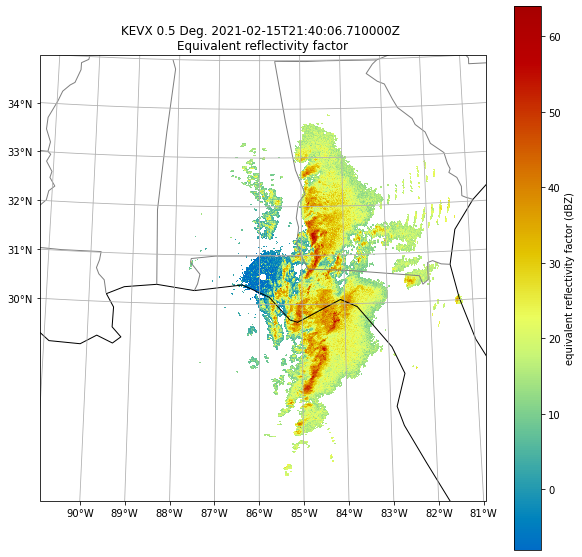

In [12]:
myf = plt.figure(figsize=[10,10])
myd = pyart.graph.RadarMapDisplay(radar)
myd.plot_ppi_map('reflectivity', 0, vmin=-8, vmax=64)

## Exercise: Fetch a high impact weather event
Can you think of an interesting case near a NEXRAD?
[![Foo](https://www.roc.noaa.gov/WSR88D/Images/CONUSLayoutNspgsW_TJUA.png)](https://www.roc.noaa.gov/WSR88D/Maps.aspx)


In [13]:
#Enter your code here

## So back to gridding
This code has been tweaked to run with 8GB memory. **This will only work on the Pangeo binder**.

In [14]:
#Lets conserve some memory
del(radar) #<--- The del command is handy!

metpy_time = recent_time
metpy_time_n = recent_time_n

# https://www.spc.noaa.gov/climo/reports/210215_rpts.html

KEOX = get_my_radar(conn, 'KEOX', metpy_time)
KEVX = get_my_radar(conn, 'KEVX', metpy_time)
KTLH = get_my_radar(conn, 'KTLH', metpy_time)

224 224
Downloaded KEOX20210215_213549_V06
1 out of 1 files downloaded...0 errors
260 260
Downloaded KEVX20210215_214006_V06
1 out of 1 files downloaded...0 errors
235 235
Downloaded KTLH20210215_213904_V06
1 out of 1 files downloaded...0 errors


In [15]:
KEOX.fields.keys()

dict_keys(['velocity', 'differential_reflectivity', 'clutter_filter_power_removed', 'reflectivity', 'cross_correlation_ratio', 'differential_phase', 'spectrum_width'])

In [16]:
#more memory conserving, lets remove a bunch of radar moments. 

for key in ['clutter_filter_power_removed','velocity', 'differential_phase' ]:
    KEOX.fields.pop(key)
    KEVX.fields.pop(key)
    KTLH.fields.pop(key)

## Introducing Gatefilters!
These will be covered in more detail in another notebook. Py-ART Gatefilters are a way of making highly configurable masks. Many (and soon all) Py-ART functions accept gatefilters. 

Here, we very simply make a gatefilter that excludes invalid (inf, nan et al) and masked values. **This can speed up gridding**.

In [17]:
KEOX_f = pyart.filters.GateFilter(KEOX)
KEOX_f.exclude_masked('reflectivity')
KEOX_f.exclude_invalid('reflectivity')

KEVX_f = pyart.filters.GateFilter(KEVX)
KEVX_f.exclude_masked('reflectivity')
KEVX_f.exclude_invalid('reflectivity')

KTLH_f = pyart.filters.GateFilter(KTLH)
KTLH_f.exclude_masked('reflectivity')
KTLH_f.exclude_invalid('reflectivity')



In [18]:
#Lets construct a grid. NOTE: Origin is at the first radar in the tuple
#This takes ~1 minute

grids = pyart.map.grid_from_radars((KEOX, KEVX, KTLH),(16,401,401),
                   ((0.,15000.),(-400000.,400000.),(-400000.,400000.)), 
                                   weighting_function='Barnes2',
                                  fields=['reflectivity','cross_correlation_ratio'],
                                  gatefilters=(KEOX_f, KEVX_f, KTLH_f))

In [19]:
# Lets convert to xarray
xgrids = grids.to_xarray()

box = (xgrids.lon.values.min(),xgrids.lon.values.max(), 
               xgrids.lat.values.min(), xgrids.lat.values.max())

In [20]:
box

(-89.52407508978176, -81.39470237603857, 27.79896471702808, 34.98348679630351)

In [21]:
#lets make sure we get our projection right!

print(grids.projection)
lon_0 = grids.get_projparams()['lon_0']
lat_0 = grids.get_projparams()['lat_0']
proj = ccrs.AzimuthalEquidistant(central_latitude=lat_0, central_longitude=lon_0)

{'proj': 'pyart_aeqd', '_include_lon_0_lat_0': True}


/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/cartopy/crs.py:2320: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a = np.float(self.globe.semimajor_axis or WGS84_SEMIMAJOR_AXIS)
/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/cartopy/crs.py:2321: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecati

Text(0.5, 0, 'Distance from radar (km)')

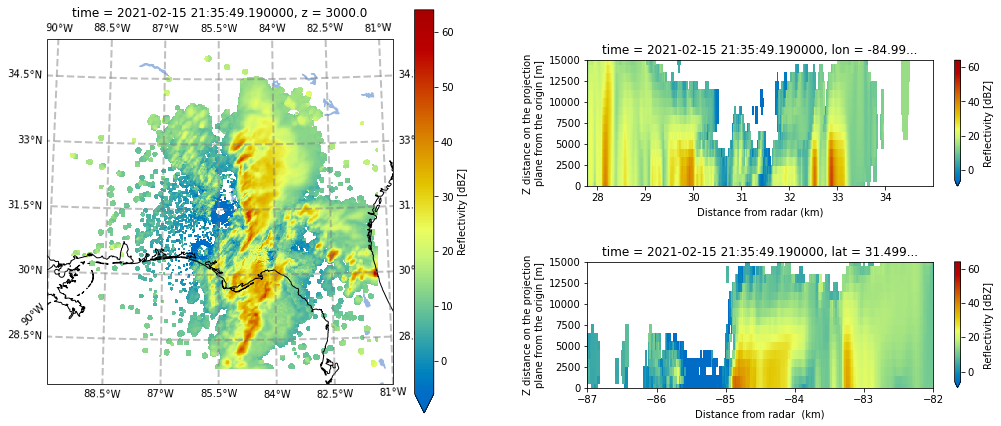

In [22]:
lalogrids = xgrids.swap_dims({"x": "lon"})
lalogrids = lalogrids.swap_dims({"y": "lat"})


fig = plt.figure(figsize=[15, 7])

# panel sizes
map_panel_axes = [0.05, 0.05, .4, .80]
x_cut_panel_axes = [0.55, 0.10, .4, .25]
y_cut_panel_axes = [0.55, 0.50, .4, .25]

# panel 1
ax1 = fig.add_axes(map_panel_axes, projection=proj)


pc = xgrids.reflectivity.sel(z=3000, 
                        time=xgrids.time[0]).plot.pcolormesh(cmap=pyart.graph.cm_colorblind.HomeyerRainbow, 
                                                             vmin=-6, vmax=64, ax = ax1)

ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.LAKES, zorder=0)

gl = ax1.gridlines(draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')




# panel 2, along longitude slice.
ax2 = fig.add_axes(x_cut_panel_axes)

pc = lalogrids.reflectivity.sel(lat=31.5, time=xgrids.time[0],method="nearest").plot.pcolormesh(cmap=pyart.graph.cm_colorblind.HomeyerRainbow,
                                                                      vmin=-6, vmax=64, ax=ax2)

ax2.set_ylim([0,15000])
ax2.set_xlim([-87,-82])
ax2.set_xlabel('Distance from radar  (km)')

# panel 3, along latitude slice
ax3 = fig.add_axes(y_cut_panel_axes)

pc = lalogrids.reflectivity.sel(lon=-85, time=xgrids.time[0],method="nearest").plot.pcolormesh(cmap=pyart.graph.cm_colorblind.HomeyerRainbow,
                                                                      vmin=-6, vmax=64, ax=ax3)

ax3.set_ylim([0,15000])

ax3.set_xlabel('Distance from radar (km)')


In [23]:
print(grids.projection)
lon_0 = grids.get_projparams()['lon_0']
lat_0 = grids.get_projparams()['lat_0']
proj = ccrs.AzimuthalEquidistant(central_latitude=lat_0, central_longitude=lon_0)

{'proj': 'pyart_aeqd', '_include_lon_0_lat_0': True}


/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/cartopy/crs.py:2320: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a = np.float(self.globe.semimajor_axis or WGS84_SEMIMAJOR_AXIS)
/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/cartopy/crs.py:2321: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecati

## Now lets use MetPy!

In [24]:
xgrids = grids.to_xarray()
lon_0 = grids.get_projparams()['lon_0']
lat_0 = grids.get_projparams()['lat_0']
proj = ccrs.AzimuthalEquidistant(central_latitude=lat_0, central_longitude=lon_0)
box = (xgrids.lon.values.min(),xgrids.lon.values.max(), 
               xgrids.lat.values.min(), xgrids.lat.values.max())

/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/cartopy/crs.py:2320: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a = np.float(self.globe.semimajor_axis or WGS84_SEMIMAJOR_AXIS)
/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/cartopy/crs.py:2321: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecati

In [25]:
# METAR information is stored in a different 
# location from the previous THREDDS catalog, 
# notice the change in URL.
metar_cat = TDSCatalog('https://thredds-test.unidata.ucar.edu/thredds/catalog/noaaport/text/metar/catalog.xml')

# Open the metar file that contains data
# closest to the satellite image time, dt
#metar_text = metar_cat.datasets.filter_time_nearest(metpy_time_n).remote_open(mode='t')
metar_text = metar_cat.datasets.filter_time_range(metpy_time_n, metpy_time_n + timedelta(hours=1))[0].remote_open(mode='t')

In [26]:
metar_text

In [27]:
# parse_metar_file() outputs a pandas DataFrame
sfc_data = parse_metar_file(metar_text, year=metpy_time_n.year, month=metpy_time_n.month)

# Save the units for all columns to a new variable
sfc_units = sfc_data.units

# Filter out missing lat/lon data
sfc_data = sfc_data[sfc_data.latitude.notna() & sfc_data.longitude.notna()]

# Set missing weather condition data to an empty string, ''
sfc_data['current_wx1'][sfc_data['current_wx1'].isna()] = ''

In [28]:
sfc_data['date_time'][100]

Timestamp('2021-02-15 21:55:00')

In [29]:

sfc_data = pandas_dataframe_to_unit_arrays(sfc_data, sfc_units)

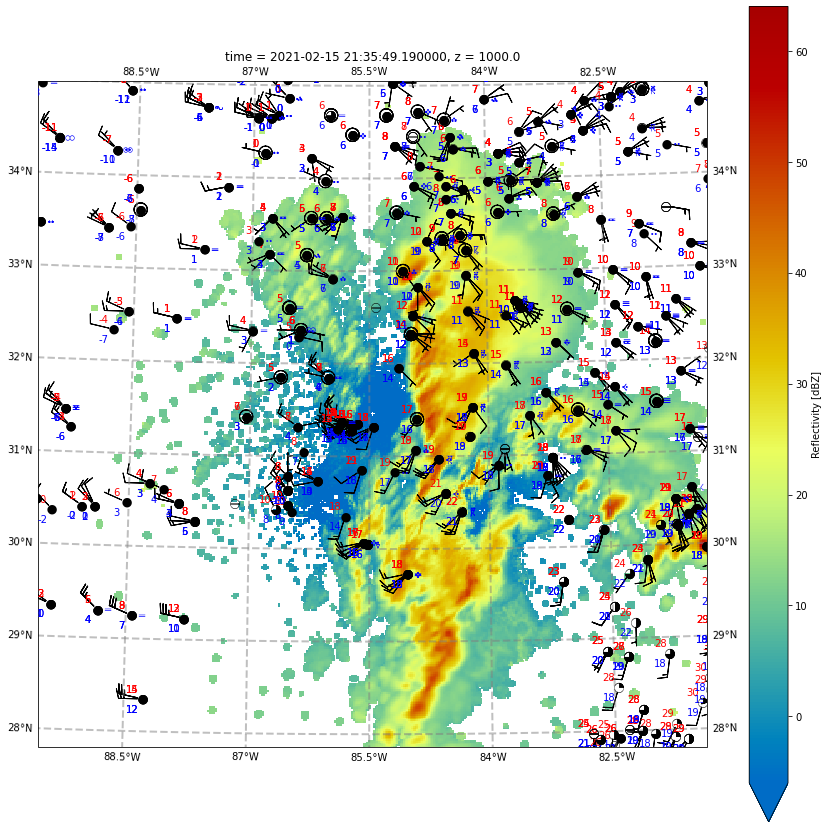

In [30]:
sfc_data['wx_code'] = mpplots.wx_code_to_numeric(sfc_data['current_wx1'])
sfc_data['u'], sfc_data['v'] = mpcalc.wind_components(sfc_data['wind_speed'], sfc_data['wind_direction'])

# Start by creating the matplotlib axes
fig = plt.figure(figsize=[15, 15])
ax = plt.axes(projection=proj)
pc = xgrids.reflectivity.sel(z=1000, method="nearest",
                        time=xgrids.time[0]).plot.pcolormesh(cmap=pyart.graph.cm_colorblind.HomeyerRainbow, 
                                                             vmin=-6, vmax=64)
gl = ax.gridlines(draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
# Create the station plot object, stn,
# from the StationPlot class, using the
# PlateCarree projection
stn = mpplots.StationPlot(ax, sfc_data['longitude'].m, sfc_data['latitude'].m, transform=ccrs.PlateCarree(),
                         clip_on=True)

# Populate the temperature and dewpoint
stn.plot_parameter('NW', sfc_data['air_temperature'], color='red')
stn.plot_parameter('SW', sfc_data['dew_point_temperature'], color='blue')

# Populate the center circle cloud coverage and weather code
stn.plot_symbol('C', sfc_data['cloud_coverage'], mpplots.sky_cover)
stn.plot_symbol('E', sfc_data['wx_code'], mpplots.current_weather, color='blue')

# Populate the wind bard
stn.plot_barb(sfc_data['u'], sfc_data['v'])


ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.LAKES, zorder=0)
ax.set_extent(box)